In [33]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sp
from scipy.fftpack import fft
from scipy.io import wavfile # get the api
import sunau;
import librosa
import librosa.display
import pandas
import os
np.set_printoptions(suppress=True)

In [ ]:
def writeMatrixToFile(self,filename,matrix):
        np.save(filename, matrix);
        os.rename(filename+".npy", filename+".txt");
        print("Written successfully..");
        pass;
    
def loadMatrixFromFile(self,filename):        
    matrix=None;
    if(os.path.isfile(filename)):
        matrix=np.load(filename);       
    return matrix;

In [34]:
class PreProcessing:
    filename=None;
    y=None;
    sr=None;
    log_enabled=True;
    centroid=None;
    spectro=None;
    spectro_phase=None;
    max_sample_vector_size=660000; 
    duration=30;
    def __init__(self,filename,duration=30):
        #self.log(filename);
        self.filename=filename;
        self.reloadAudioFile(duration);
        self.duration=duration;
        pass;
    
    def reloadAudioFile(self,duration=30):
        self.y, self.sr = librosa.load(self.filename,duration=duration);
        self.y=self.y[:self.max_sample_vector_size];
        pass;
    
    #Short-Term-Fourier trasform
    def getSTFT(self):
        self.stft=librosa.stft(y=self.y);
        return self.stft;
        pass;
    
    #spectro graph
    def getSpectrogram(self):
        stft=self.getSTFT();
        self.spectro, self.spectro_phase = librosa.magphase(stft);        
        return self.spectro, self.spectro_phase;
        pass;
    
    def getCentroid(self):
        self.centroid=librosa.feature.spectral_centroid(y=self.y,sr=self.sr);
        return self.centroid;    

    def getSpectralRolloff(self):
        self.rolloff=librosa.feature.spectral_rolloff(y=self.y, sr=self.sr);
        return self.rolloff;
    
    def getZeroCrossing(self):
        self.zero_crossing_rate=librosa.feature.zero_crossing_rate(self.y);
        return self.zero_crossing_rate;
    
    def getSpectralContrast(self):
        #Jiang, Dan-Ning, Lie Lu, Hong-Jiang Zhang, Jian-Hua Tao, and Lian-Hong Cai. “Music type classification by spectral contrast feature.” In Multimedia and Expo, 2002. ICME‘02. Proceedings. 2002 IEEE International Conference on, vol. 1, pp. 113-116. IEEE, 2002.
        S = np.abs(self.getSTFT());
        self.contrast = librosa.feature.spectral_contrast(S=S, sr=self.sr);
        return self.contrast;
    
    def getMFCC(self):
        self.mfcc = librosa.feature.mfcc(y=self.y, sr=self.sr, hop_length=512, n_mfcc=13);
        return self.mfcc;
    
    def getRMS(self):
        self.rms=librosa.feature.rmse(y=self.y);
        return self.rms;

    def drawRMS(self):
        rms=self.getRMS();
        S,phase=self.getSpectrogram();
        plt.figure()
        plt.subplot(2, 1, 1)
        plt.semilogy(rms.T, label='RMS Energy')
        plt.xticks([])
        plt.xlim([0, rms.shape[-1]])
        plt.legend(loc='best')
        plt.subplot(2, 1, 2)
        librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),y_axis='log', x_axis='time')
        plt.title('log Power spectrogram')
        plt.tight_layout()
        plt.show();
        pass;
    
    def drawSpectrogramWithCentroid(self):
        centroid=self.getCentroid();
        S,phase=self.getSpectrogram();
        plt.figure()
        plt.subplot(2, 1, 1)
        plt.semilogy(centroid.T, label='Spectral centroid')
        plt.ylabel('Hz')
        plt.xticks([])
        plt.xlim([0, centroid.shape[-1]])
        plt.legend()
        plt.subplot(2, 1, 2)
        librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),y_axis='log', x_axis='time')
        plt.title('log Power spectrogram')
        plt.tight_layout();
        plt.show();
        pass;
    
    def drawSpectralRolloff(self):
        rolloff=self.getSpectralRolloff();
        S,phase=self.getSpectrogram();
        plt.figure()
        plt.subplot(2, 1, 1)
        plt.semilogy(rolloff.T, label='Roll-off frequency')
        plt.ylabel('Hz')
        plt.xticks([])
        plt.xlim([0, rolloff.shape[-1]])
        plt.legend()
        plt.subplot(2, 1, 2)
        librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),y_axis='log', x_axis='time')
        plt.title('log Power spectrogram')
        plt.tight_layout();
        plt.show();
        pass;
    
    def drawSpectralContrast(self):
        contrast=self.getSpectralContrast();
        S,phase=self.getSpectrogram();
        S = np.abs(self.getSTFT());
        plt.figure()
        plt.subplot(2, 1, 1)
        librosa.display.specshow(librosa.amplitude_to_db(S,ref=np.max),y_axis='log')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Power spectrogram')
        plt.subplot(2, 1, 2)
        librosa.display.specshow(contrast, x_axis='time')
        plt.colorbar()
        plt.ylabel('Frequency bands')
        plt.title('Spectral contrast')
        plt.tight_layout();
        plt.show();
        pass;
    
    def drawMFCC(self):
        mfccs=self.getMFCC();
        plt.figure(figsize=(6, 4))
        librosa.display.specshow(mfccs, x_axis='time')
        #plt.colorbar()
        plt.title('MFCC')
        plt.tight_layout()
        plt.show();
        pass;
    
    
    def log(self,a,b=None):
        if(self.log_enabled):
            if(b!=None):
                print(a,b);
            else:
                print(a);
        pass;  


In [50]:
class ProcessDataset:
    columns = ["id","type","y","centroid mean","centroid var","rolloff mean","rolloff var","zero mean","zero var","rms mean","rms var","contrast mean","contrast var","mfcc1 mean","mfcc1 var","mfcc2 mean","mfcc2 var","mfcc3 mean","mfcc3 var","mfcc4 mean","mfcc4 var","mfcc5 mean","mfcc5 var"];
    genre_out={"blues":[1,0,0,0,0,0,0,0,0,0],"classical":[0,1,0,0,0,0,0,0,0,0],"country":[0,0,1,0,0,0,0,0,0,0],"disco":[0,0,0,1,0,0,0,0,0,0],"hiphop":[0,0,0,0,1,0,0,0,0,0],"jazz":[0,0,0,0,0,1,0,0,0,0],"metal":[0,0,0,0,0,0,1,0,0,0],"pop":[0,0,0,0,0,0,0,1,0,0],"reggae":[0,0,0,0,0,0,0,0,1,0],"rock":[0,0,0,0,0,0,0,0,0,1]};
    dataframe=None;
    mfcc_features=5;
    dir="../genres";
    genre_dir={"blues":"blues","classical":"classical","country":"country","disco":"disco","hiphop":"hiphop","jazz":"jazz","metal":"metal","pop":"pop","reggae":"reggae","rock":"rock"};
    def __init__(self):
        self.dataframe = pandas.DataFrame(columns=self.columns);
        pass;

    def extractTimberalFeatures(self,genre,audio_number,filename):
        features=[];
        pp=PreProcessing(filename);            
        centroid=pp.getCentroid()[0];
        rolloff=pp.getSpectralRolloff()[0];        
        zero=pp.getZeroCrossing()[0];        
        contrast=pp.getSpectralContrast()[0];        
        rms=pp.getRMS()[0];
        mfcc=rms=pp.getMFCC();
        
        features.append(audio_number);
        features.append(genre);        
        features.append(self.genre_out[genre]);
        features.append(centroid.mean());
        features.append(centroid.var()); 
        features.append(rolloff.mean());
        features.append(rolloff.var()); 
        features.append(zero.mean());
        features.append(zero.var()); 
        features.append(rms.mean());
        features.append(rms.var()); 
        features.append(contrast.mean());
        features.append(contrast.var()); 
        for i in range(self.mfcc_features):
            features.append(mfcc[i].mean());
            features.append(mfcc[i].var());             
        self.dataframe.loc[self.dataframe.size]=features;
    
    def saveDataFrame(self):
        filename="audiofeatures_numpy_matrix";
        arr=self.dataframe.as_matrix(columns=None);
        np.save(filename,arr);       
        self.dataframe.to_csv("audiofeatures.csv",sep=",")
        print("Written successfully..");
        pass;
    
    def extractFeatures(self):
        print("Extracting Features...");
        percent_completed=0;        
        for k in self.genre_dir:    
            genre=k;
            print("-------------------["+genre+"]-----------------------")
            for i in range(100):
                audio_number="%0.5d"%i;
                filename=self.dir+"/"+self.genre_dir[genre]+"/"+self.genre_dir[genre]+"."+audio_number+".au";              
                self.extractTimberalFeatures(genre,audio_number,filename);  
                percent_completed=i;
                if(percent_completed%10==0):
                    print("Percent completed:",percent_completed);            
        self.saveDataFrame();
        print("Extraction done");
        pass;
        

In [51]:
p1=ProcessDataset();
p1.extractFeatures();
p1.dataframe

Extracting Features...
-------------------[reggae]-----------------------
('Percent completed:', 0)
('Percent completed:', 10)
('Percent completed:', 20)
('Percent completed:', 30)
('Percent completed:', 40)
('Percent completed:', 50)
('Percent completed:', 60)
('Percent completed:', 70)
('Percent completed:', 80)
('Percent completed:', 90)
-------------------[hiphop]-----------------------
('Percent completed:', 0)
('Percent completed:', 10)
('Percent completed:', 20)
('Percent completed:', 30)
('Percent completed:', 40)
('Percent completed:', 50)
('Percent completed:', 60)
('Percent completed:', 70)
('Percent completed:', 80)
('Percent completed:', 90)
-------------------[classical]-----------------------
('Percent completed:', 0)
('Percent completed:', 10)
('Percent completed:', 20)
('Percent completed:', 30)
('Percent completed:', 40)
('Percent completed:', 50)
('Percent completed:', 60)
('Percent completed:', 70)
('Percent completed:', 80)
('Percent completed:', 90)
--------------

id    type                               y  centroid mean  \
0      00000  reggae  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]    2133.438680   
23     00001  reggae  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]    1638.628474   
46     00002  reggae  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]    1797.330407   
69     00003  reggae  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]    1921.356643   
92     00004  reggae  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]    2008.862972   
115    00005  reggae  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]    1799.045290   
138    00006  reggae  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]    1418.146671   
161    00007  reggae  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]    1754.227409   
184    00008  reggae  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]    1692.907524   
207    00009  reggae  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]    1608.693907   
230    00010  reggae  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]    2151.287072   
253    00011  reggae  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]    1996.089895   
276    00012  reggae  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]    2299.476688   
299    00013  reggae  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]    1606.011672   
322    00014  reggae  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]    1717.121826   
345    00015  reggae  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]    1924.807225   
368    00016  reggae  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]    2117.595663   
391    00017  reggae  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]    1802.716373   
414    00018  reggae  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]    1906.178268   
437    00019  reggae  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]    1754.142225   
460    00020  reggae  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]    1638.971872   
483    00021  reggae  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]    2008.744368   
506    00022  reggae  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]    2059.124666   
529    00023  reggae  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]    2354.062751   
552    00024  reggae  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]    1812.173822   
575    00025  reggae  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]    1708.765839   
598    00026  reggae  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]    1840.261817   
621    00027  reggae  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]    2086.331612   
644    00028  reggae  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]    1641.849903   
667    00029  reggae  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]    1585.737668   
...      ...     ...                             ...            ...   
22310  00070   disco  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]    2449.052949   
22333  00071   disco  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]    2809.023526   
22356  00072   disco  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]    2902.798908   
22379  00073   disco  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]    2845.563826   
22402  00074   disco  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]    2650.237076   
22425  00075   disco  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]    2690.332534   
22448  00076   disco  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]    2252.588756   
22471  00077   disco  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]    2307.959620   
22494  00078   disco  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]    2219.051361   
22517  00079   disco  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]    2293.436927   
22540  00080   disco  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]    2138.798635   
22563  00081   disco  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]    2291.572766   
22586  00082   disco  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]    2576.881872   
22609  00083   disco  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]    1960.186781   
22632  00084   disco  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]    2454.924023   
22655  00085   disco  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]    3000.432734   
22678  00086   disco  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]    1867.215271   
22701  00087   disco  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]    2138.185590   
22724  00088   disco  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]    2238.891952   
22747  00089   disco  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]    2129.654812   
22770  00090   disco  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]    2574.704284   
22793  00091   disco  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]    2035.122760   
22816  00092   disco  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]    2459.392583   
22839  00093   disco  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]    2462.064759   
22862  00094   disco  [0, 0, 0, 1,

In [ ]:
dir="../genres";
genre_dir={"blues":"blues","classical":"classical","country":"country","disco":"disco","hiphop":"hiphop","jazz":"jazz","metal":"metal","pop":"pop","reggae":"reggae","rock":"rock"};

In [99]:
genre="blues"
pds=ProcessDataset();

audio_number="%0.5d"%0;
filename=dir+"/"+genre_dir[genre]+"/"+genre_dir[genre]+"."+audio_number+".au";  
pds.extractTimberalFeatures(genre,audio_number,filename);

audio_number="%0.5d"%1;
filename=dir+"/"+genre_dir[genre]+"/"+genre_dir[genre]+"."+audio_number+".au";  
pds.extractTimberalFeatures(genre,audio_number,filename);

audio_number="%0.5d"%2;
filename=dir+"/"+genre_dir[genre]+"/"+genre_dir[genre]+"."+audio_number+".au";  
pds.extractTimberalFeatures(genre,audio_number,filename);

#pds.extractFeatures();
pds.dataframe

../genres/blues/blues.00000.au
[ 2175.02383202  2103.86995659  1955.28566719 ...,  1733.51625061
  1639.52218235  1460.39008199]
../genres/blues/blues.00001.au
[  886.23526605  1052.00867559  1125.26707053 ...,  2134.12080494
  2161.0355874   1978.12479632]
../genres/blues/blues.00002.au
[ 1489.66012402  1423.92421802  1386.4249223  ...,  1668.02497412
  2022.81568009  2326.08081229]


id   type                               y  centroid mean  \
0   00000  blues  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]    1784.808293   
23  00001  blues  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]    1529.004413   
46  00002  blues  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]    1552.846406   

     centroid var  rolloff mean   rolloff var  zero mean  zero var  rms mean  \
0   129887.506323   3808.046818  9.014349e+05   0.083024  0.000768  3.117747   
23  376097.671445   3545.433548  2.973528e+06   0.055998  0.001450 -0.015549   
46  157139.525334   3041.990598  7.870677e+05   0.076251  0.001009  3.360072   

       ...      mfcc1 mean    mfcc1 var  mfcc2 mean   mfcc2 var  mfcc3 mean  \
0      ...     -113.610381  2569.194411  121.526927  295.745460  -19.119716   
23     ...     -207.681018  7768.972485  124.028813  561.000281    8.921462   
46     ...      -90.777321  3325.262959  140.435236  511.089229  -29.103523   

     mfcc3 var  mfcc4 mean   mfcc4 var  mfcc5 mean   mfcc5 var  
0   234.920347   42.345833  150.987558   -6.397207  167.927718  
23  573.457567   35.872568  265.096775    2.953947  279.591975  
46  412.718063   31.721170  144.410624  -14.020489  155.647027  

[3 rows x 23 columns]

-------------------[reggae]-----------------------


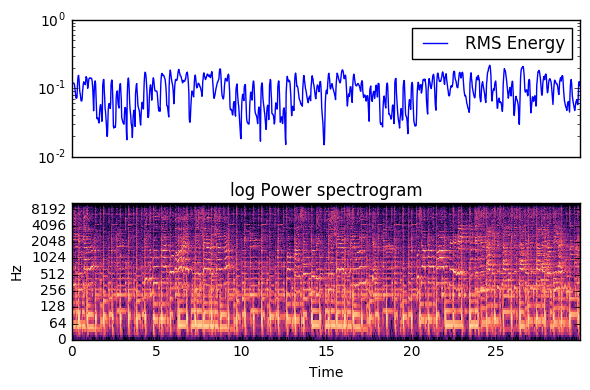

[[ 0.12273667  0.12186102  0.12016046 ...,  0.12420224  0.12463597
   0.10943095]]
(0, ':', 1286, ' ylen:', 660000, ' sr:', 22050)
-------------------[hiphop]-----------------------


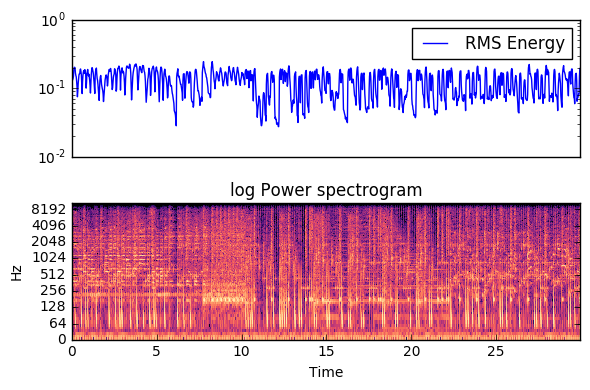

[[ 0.12211477  0.1281797   0.13319688 ...,  0.08236709  0.14747226
   0.19405326]]
(0, ':', 1286, ' ylen:', 660000, ' sr:', 22050)
-------------------[classical]-----------------------


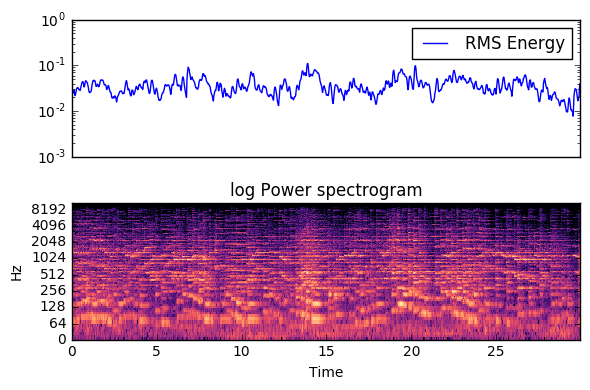

[[ 0.02758028  0.02660531  0.02396603 ...,  0.02070745  0.0311012
   0.03931727]]
(0, ':', 1286, ' ylen:', 660000, ' sr:', 22050)
-------------------[rock]-----------------------


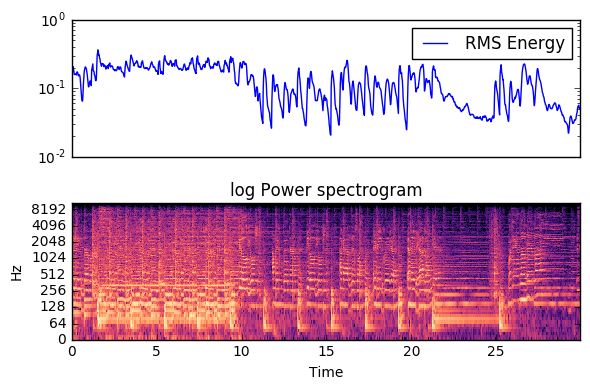

[[ 0.12055855  0.16294394  0.19036479 ...,  0.05357637  0.05036627
   0.05064309]]
(0, ':', 1286, ' ylen:', 660000, ' sr:', 22050)
-------------------[country]-----------------------


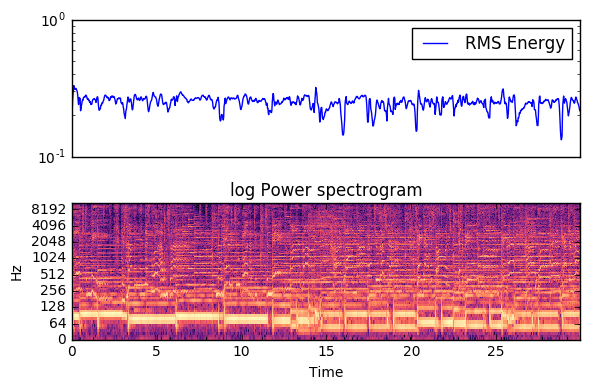

[[ 0.22345297  0.22170462  0.26306298 ...,  0.23193562  0.22169882
   0.21640648]]
(0, ':', 1286, ' ylen:', 660000, ' sr:', 22050)
-------------------[blues]-----------------------


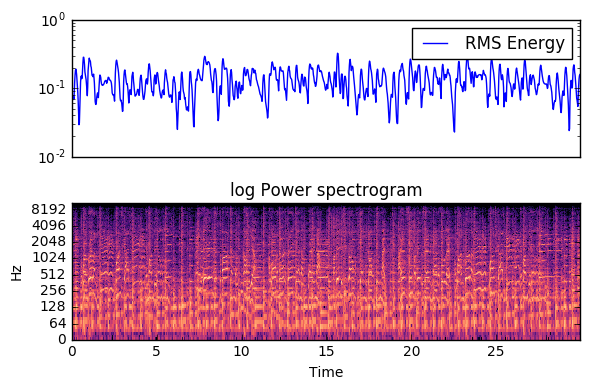

[[ 0.0497628   0.06394323  0.07329978 ...,  0.13698375  0.15247679
   0.15843858]]
(0, ':', 1286, ' ylen:', 660000, ' sr:', 22050)
-------------------[jazz]-----------------------


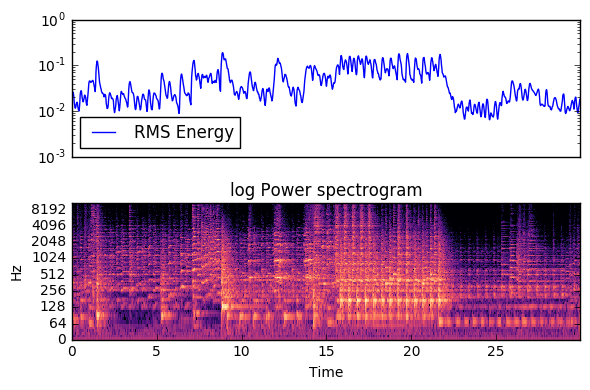

[[ 0.01803598  0.02228236  0.02586798 ...,  0.01322496  0.01581257
   0.01810335]]
(0, ':', 1286, ' ylen:', 660000, ' sr:', 22050)
-------------------[metal]-----------------------


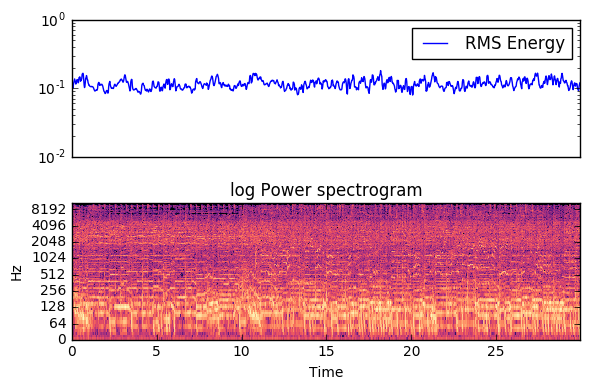

[[ 0.10696381  0.10252804  0.10301883 ...,  0.10626326  0.11188358
   0.11951169]]
(0, ':', 1286, ' ylen:', 660000, ' sr:', 22050)
-------------------[pop]-----------------------


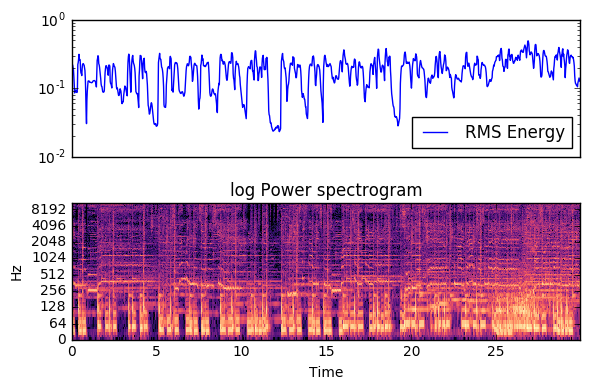

[[ 0.21247801  0.21798654  0.2187013  ...,  0.14100413  0.13393529
   0.12657666]]
(0, ':', 1286, ' ylen:', 660000, ' sr:', 22050)
-------------------[disco]-----------------------


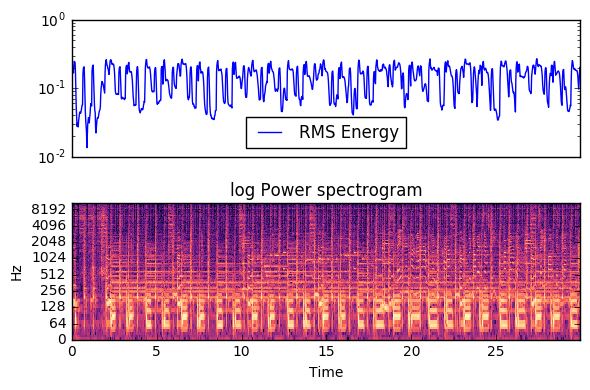

[[ 0.21374369  0.20610018  0.19885674 ...,  0.12517156  0.16999564
   0.20123817]]
(0, ':', 1286, ' ylen:', 660000, ' sr:', 22050)


In [32]:
#RMS
for k in genre_dir:    
    genre=k;
    print("-------------------["+genre+"]-----------------------")
    ta=[];
    for i in range(1):
        audio_number="%0.5d"%i;
        filename=dir+"/"+genre_dir[genre]+"/"+genre_dir[genre]+"."+audio_number+".au"; 
        pp=PreProcessing(filename);        
        pp.drawRMS();
        print(pp.getRMS()); 
        ta.append(len(pp.y));
        print(i,":",len(pp.getRMS()[0])," ylen:",len(pp.y)," sr:",pp.sr); 
    #break;

-------------------[reggae]-----------------------


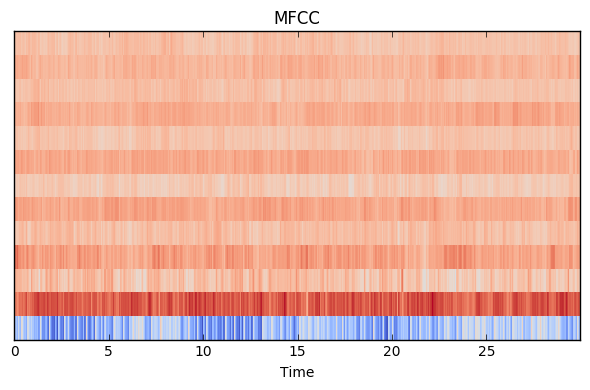

[[-124.57855276 -131.04084016 -144.74713664 ..., -125.91194846
  -158.74996883 -166.38943691]
 [  78.83006367   76.22253629   71.34627837 ...,  113.24257398
   109.67884892  107.95713009]
 [   6.97630006   10.42185458   11.61896887 ...,  -12.15354339
   -18.56434565  -22.99500938]
 ..., 
 [ -17.97305013  -14.85311877  -12.02719461 ...,  -22.21880045
   -28.12110394  -25.95976496]
 [  11.76659489   14.06402842   13.59665085 ...,   16.78087551
    11.54450507   11.1070932 ]
 [ -14.68518139  -12.68146771  -15.88183775 ...,  -10.18164568
   -14.83093545  -18.3554949 ]]
(0, ':', 1290, ' ylen:', 660000, ' sr:', 22050)


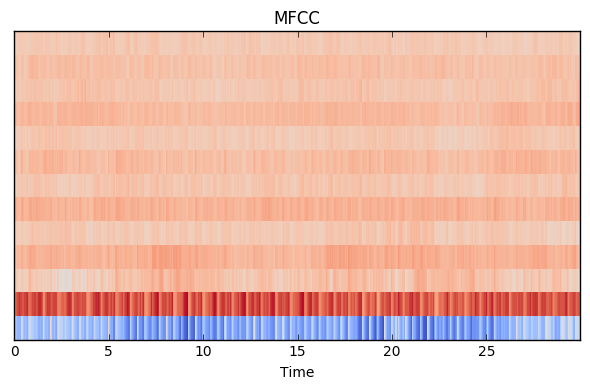

[[-124.39241092 -108.92179376 -120.50534286 ..., -106.2741599  -115.34373702
  -122.65444037]
 [  96.15123384   86.379884     85.56862623 ...,  125.99795924
   126.07660603  120.61563041]
 [  -2.98856325   -1.43805253   -3.15877348 ...,  -46.41286149  -47.1206323
   -46.26778341]
 ..., 
 [  -9.02177588  -18.00242962  -22.30388732 ...,   10.59306158
     9.74792801   10.03122292]
 [  -6.04606292   -3.59538501   -2.73015247 ...,   -1.09623601
    -7.47540101  -10.5679006 ]
 [ -20.60568275  -24.60019451  -29.04742757 ...,  -33.57064612  -32.2075245
   -28.17981132]]
(1, ':', 1290, ' ylen:', 660000, ' sr:', 22050)


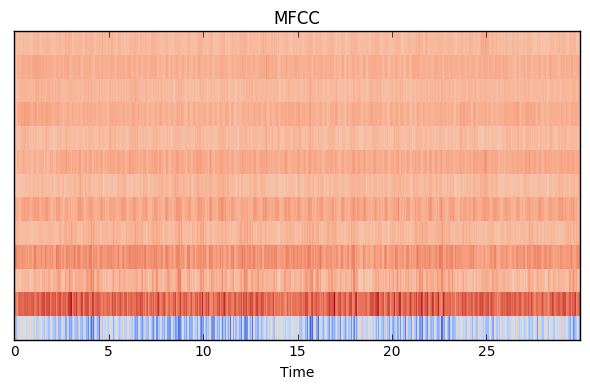

[[-160.94976286 -170.96441492 -193.53514018 ..., -161.85706866
  -200.05471194 -236.07861681]
 [  67.14069961   70.95600309   74.87466892 ...,   98.12090339
   112.04644605  125.95302477]
 [   7.4449593    -6.03008322  -21.87575177 ...,  -25.84741376
   -33.27219274  -28.30046257]
 ..., 
 [ -14.13580348  -21.93129113  -29.24908307 ...,   -1.99804962
     1.39076563    5.06239854]
 [   6.73154025    6.899515      0.45324477 ...,   11.93890688    2.6511609
    -0.40675402]
 [  -1.9939216    -4.49236887  -10.70930693 ...,  -28.73301209
   -29.38520173  -29.083249  ]]
(2, ':', 1290, ' ylen:', 660000, ' sr:', 22050)


In [24]:
#MFCC
for k in genre_dir:    
    genre=k;
    print("-------------------["+genre+"]-----------------------")
    ta=[];
    for i in range(3):
        audio_number="%0.5d"%i;
        filename=dir+"/"+genre_dir[genre]+"/"+genre_dir[genre]+"."+audio_number+".au"; 
        pp=PreProcessing(filename);        
        pp.drawMFCC();
        print(pp.getMFCC()); 
        ta.append(len(pp.y));
        print(i,":",len(pp.getMFCC()[0])," ylen:",len(pp.y)," sr:",pp.sr); 
    break;

In [15]:
#Zero crossing
for k in genre_dir:    
    genre=k;
    print("-------------------["+genre+"]-----------------------")
    ta=[];
    for i in range(10):
        audio_number="%0.5d"%i;
        filename=dir+"/"+genre_dir[genre]+"/"+genre_dir[genre]+"."+audio_number+".au"; 
        pp=PreProcessing(filename,10);
        print(pp.getZeroCrossing()); 
        ta.append(len(pp.y));
        print(i,":",len(pp.getZeroCrossing()[0])," ylen:",len(pp.y)," sr:",pp.sr); 
    break;


-------------------[reggae]-----------------------
[[ 0.06005859  0.08886719  0.11816406  0.11279297  0.11914062  0.11816406
   0.11230469  0.10205078  0.11425781  0.13232422  0.15039062  0.15380859
   0.12744141  0.10205078  0.08056641  0.11083984  0.11669922  0.11328125
   0.1171875   0.09423828  0.10107422  0.10302734  0.09472656  0.08642578
   0.08398438  0.09375     0.08740234  0.07080078  0.05224609  0.06884766
   0.10449219  0.14013672  0.16699219  0.15820312  0.140625    0.12402344
   0.11376953  0.10742188  0.10546875  0.11132812  0.10253906  0.08544922
   0.08398438  0.07421875  0.07910156  0.08837891  0.08300781  0.07910156
   0.07275391  0.06640625  0.06494141  0.06689453  0.06835938  0.06835938
   0.06738281  0.06445312  0.0625      0.06982422  0.08105469  0.09277344
   0.08837891  0.07275391  0.07177734  0.06787109  0.08300781  0.10644531
   0.10791016  0.10595703  0.09960938  0.09130859  0.10058594  0.09863281
   0.10546875  0.09375     0.07275391  0.06298828  0.04394531

[[ 0.03808594  0.05810547  0.078125    0.08007812  0.08251953  0.07958984
   0.07568359  0.07568359  0.07519531  0.078125    0.08154297  0.078125
   0.06884766  0.06201172  0.07910156  0.11035156  0.12451172  0.13232422
   0.11035156  0.07275391  0.05664062  0.04443359  0.03369141  0.02880859
   0.02197266  0.02197266  0.04541016  0.06054688  0.07568359  0.10546875
   0.09814453  0.10058594  0.11914062  0.09423828  0.09228516  0.08105469
   0.05615234  0.0546875   0.05761719  0.06298828  0.05566406  0.05273438
   0.046875    0.03808594  0.03662109  0.03759766  0.02539062  0.02294922
   0.02050781  0.02294922  0.05371094  0.09863281  0.13183594  0.15966797
   0.14648438  0.12597656  0.10351562  0.12597656  0.18408203  0.23583984
   0.25878906  0.21142578  0.14453125  0.06689453  0.03320312  0.02050781
   0.01660156  0.03076172  0.04003906  0.04199219  0.05029297  0.04833984
   0.05712891  0.06347656  0.06347656  0.05908203  0.05419922  0.06054688
   0.05273438  0.06884766  0.09814453  0

[[ 0.04296875  0.06347656  0.08300781  0.07861328  0.07714844  0.06298828
   0.046875    0.03417969  0.02197266  0.02734375  0.04199219  0.07714844
   0.12011719  0.15625     0.17919922  0.16503906  0.14355469  0.12158203
   0.10595703  0.09521484  0.08544922  0.09375     0.10400391  0.125
   0.13818359  0.14013672  0.13818359  0.14111328  0.13720703  0.12597656
   0.10986328  0.07568359  0.05273438  0.03076172  0.01708984  0.01464844
   0.01269531  0.01464844  0.02050781  0.0390625   0.06542969  0.08105469
   0.08154297  0.06298828  0.03759766  0.02832031  0.04492188  0.07080078
   0.09863281  0.12548828  0.13330078  0.13623047  0.14355469  0.14306641
   0.14111328  0.13623047  0.12158203  0.10595703  0.08740234  0.06201172
   0.04296875  0.02197266  0.01904297  0.02490234  0.02880859  0.03466797
   0.02539062  0.02001953  0.01367188  0.00976562  0.00976562  0.01513672
   0.02978516  0.06640625  0.09570312  0.09765625  0.09082031  0.05664062
   0.03710938  0.03466797  0.03808594  0.06

[[ 0.05322266  0.08251953  0.11376953  0.10693359  0.11083984  0.10009766
   0.09326172  0.09716797  0.08984375  0.09130859  0.09619141  0.18017578
   0.21386719  0.24365234  0.24511719  0.15185547  0.12939453  0.10986328
   0.10205078  0.09960938  0.08740234  0.08398438  0.09716797  0.09814453
   0.09277344  0.07226562  0.08251953  0.09619141  0.09667969  0.09912109
   0.06005859  0.04003906  0.03466797  0.03076172  0.03027344  0.02197266
   0.01855469  0.01464844  0.00976562  0.01904297  0.02441406  0.03027344
   0.04443359  0.04931641  0.06445312  0.09228516  0.11425781  0.11865234
   0.109375    0.08496094  0.06054688  0.05126953  0.05078125  0.04882812
   0.05029297  0.05224609  0.06005859  0.08349609  0.09130859  0.09228516
   0.08349609  0.06542969  0.06005859  0.04882812  0.04833984  0.04833984
   0.04394531  0.04785156  0.05273438  0.04882812  0.04345703  0.04882812
   0.04248047  0.04638672  0.06396484  0.06982422  0.07519531  0.08300781
   0.08447266  0.10986328  0.15429688 

[[ 0.00488281  0.00927734  0.01855469  0.05908203  0.05957031  0.06005859
   0.05419922  0.01318359  0.01757812  0.02392578  0.08789062  0.23925781
   0.28466797  0.29833984  0.25390625  0.11572266  0.07275391  0.05664062
   0.04736328  0.046875    0.06494141  0.05957031  0.05029297  0.03710938
   0.01171875  0.01025391  0.01171875  0.04882812  0.07763672  0.08789062
   0.08642578  0.05566406  0.02685547  0.01660156  0.01367188  0.00732422
   0.00683594  0.00927734  0.01123047  0.01904297  0.02490234  0.02880859
   0.03564453  0.03564453  0.17285156  0.22167969  0.23730469  0.25244141
   0.13085938  0.08837891  0.07128906  0.05566406  0.04296875  0.046875
   0.04882812  0.04199219  0.03515625  0.02148438  0.01220703  0.01171875
   0.01025391  0.00830078  0.01367188  0.01660156  0.01806641  0.02246094
   0.02001953  0.02050781  0.03369141  0.06396484  0.06347656  0.06103516
   0.04736328  0.01318359  0.01269531  0.02197266  0.06835938  0.15185547
   0.17382812  0.17041016  0.12695312  0

-------------------[reggae]-----------------------


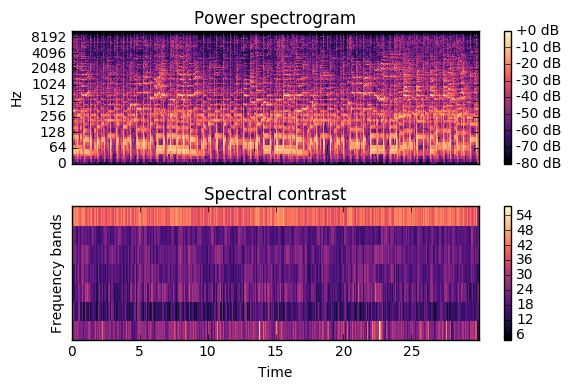

[[ 22.71549441  15.14641409  24.14103888 ...,  24.0971926   11.29898951
   13.27905452]
 [ 11.50257414  14.95473004  25.01722861 ...,  13.3039732   18.12776243
   20.33329271]
 [ 22.16321618  16.26206978  19.98304189 ...,  11.92659261  19.58846898
   27.47181369]
 ..., 
 [ 28.96823106  25.63456507  24.62169934 ...,  20.72708131  21.62251376
   22.87970379]
 [ 32.82884718  21.34650882  22.82487534 ...,  16.78565541  19.45012432
   22.70728256]
 [ 43.25129628  43.15184264  43.58592124 ...,  41.92959979  26.12213442
   26.04820982]]
(0, ':', 1290, ' ylen:', 660000, ' sr:', 22050)


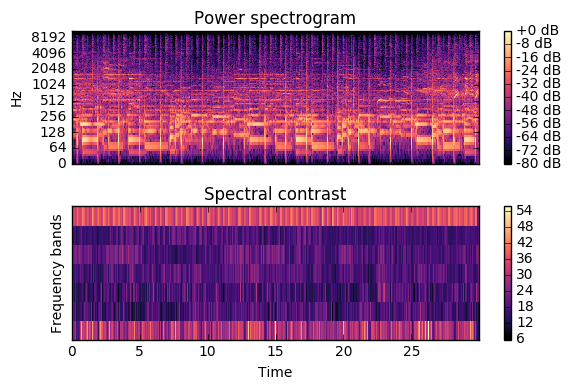

[[ 26.69729204  21.92561405  27.20060639 ...,  22.83330842  14.83752841
   13.32924517]
 [ 27.11545937  12.9226074   13.97953788 ...,  16.87664973  16.02947896
   12.68058878]
 [ 22.86608421  15.72593091  16.24853143 ...,  24.82935764  20.74957212
   24.04338804]
 ..., 
 [ 31.62050838  21.16284515  21.21731888 ...,  20.19578157  22.64690268
   26.85769112]
 [ 23.56050085  13.17225608  12.70923315 ...,  17.05317247  14.21589509
   21.65304588]
 [ 23.97697691  20.31929461  43.99839347 ...,  39.80147663  21.46795618
   23.84082228]]
(1, ':', 1290, ' ylen:', 660000, ' sr:', 22050)


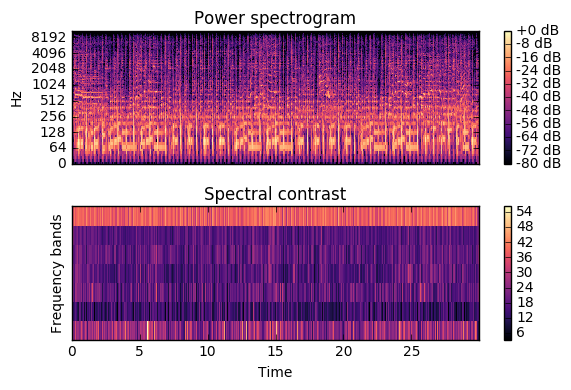

[[  9.46031549   8.34019443  14.85085783 ...,  21.66856103  13.93798754
   10.34580484]
 [ 12.4699183   10.57274265  12.15534535 ...,  14.77090769  15.89683043
   16.78498116]
 [ 22.71598366  16.88746579  20.43431609 ...,  16.43383903  20.65705666
   26.25620825]
 ..., 
 [ 29.30127936  21.81515025  19.58894955 ...,  22.659572    19.60740588
   27.20295147]
 [ 26.92079168  20.06410451  18.92851425 ...,  21.8268867   19.29006184
   21.73633906]
 [ 22.2934563   15.78147321  36.80368854 ...,  35.83392206  28.29308805
   25.34854846]]
(2, ':', 1290, ' ylen:', 660000, ' sr:', 22050)


In [155]:
#Spectral Contrast
for k in genre_dir:    
    genre=k;
    print("-------------------["+genre+"]-----------------------")
    ta=[];
    for i in range(3):
        audio_number="%0.5d"%i;
        filename=dir+"/"+genre_dir[genre]+"/"+genre_dir[genre]+"."+audio_number+".au"; 
        pp=PreProcessing(filename);
        pp.drawSpectralContrast();
        print(pp.getSpectralContrast());
        ta.append(len(pp.y));
        print(i,":",len(pp.getSpectralContrast()[0])," ylen:",len(pp.y)," sr:",pp.sr); 
    break;
    

-------------------[reggae]-----------------------


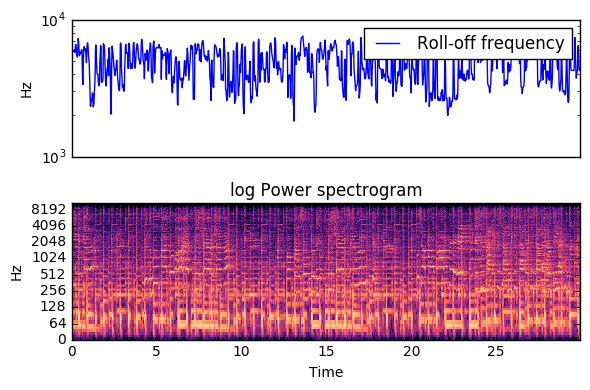

[[ 5630.93261719  5964.69726562  5996.99707031 ...,  4435.83984375
   4263.57421875  4274.34082031]]
(0, ':', 1290, ' ylen:', 660000, ' sr:', 22050)


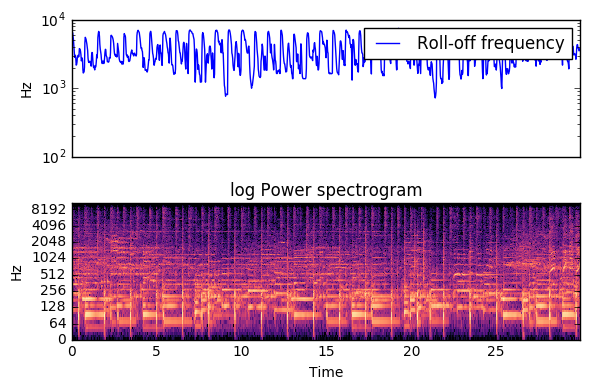

[[ 5630.93261719  6395.36132812  6481.49414062 ...,  3509.91210938
   3552.97851562  3757.54394531]]
(1, ':', 1290, ' ylen:', 660000, ' sr:', 22050)


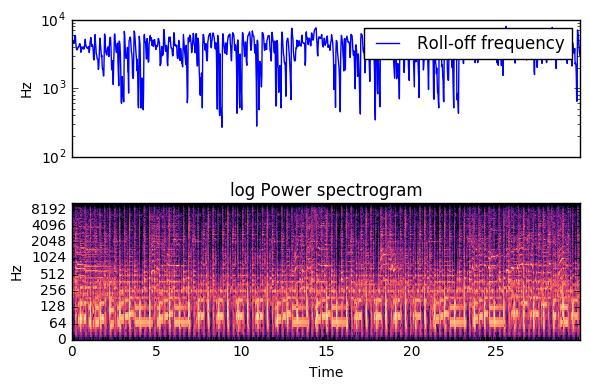

[[ 5673.99902344  5340.234375    4791.13769531 ...,  4155.90820312
   3359.1796875   3036.18164062]]
(2, ':', 1290, ' ylen:', 660000, ' sr:', 22050)


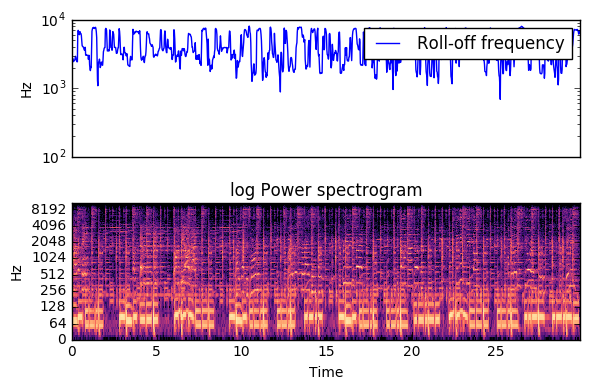

[[ 2680.88378906  2648.58398438  2691.65039062 ...,  6276.92871094
   6933.69140625  6524.56054688]]
(3, ':', 1290, ' ylen:', 660000, ' sr:', 22050)


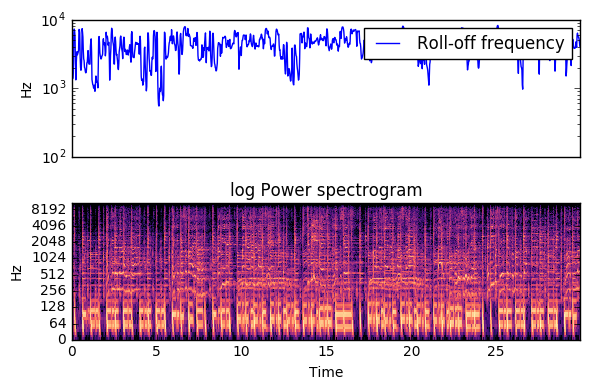

[[ 2594.75097656  2207.15332031  1378.125      ...,  5211.03515625
   4715.77148438  4112.84179688]]
(4, ':', 1290, ' ylen:', 660000, ' sr:', 22050)


KeyboardInterrupt: 

In [145]:
#SpectralRolloff
for k in genre_dir:    
    genre=k;
    print("-------------------["+genre+"]-----------------------")
    ta=[];
    for i in range(10):
        audio_number="%0.5d"%i;
        filename=dir+"/"+genre_dir[genre]+"/"+genre_dir[genre]+"."+audio_number+".au"; 
        pp=PreProcessing(filename);
        pp.drawSpectralRolloff();
        print(pp.getSpectralRolloff()); 
        ta.append(len(pp.y));
        print(i,":",len(pp.getSpectralRolloff()[0])," ylen:",len(pp.y)," sr:",pp.sr);    
    print(genre," ymin:",np.min(ta),' max:',np.max(ta));
    break;


-------------------[reggae]-----------------------


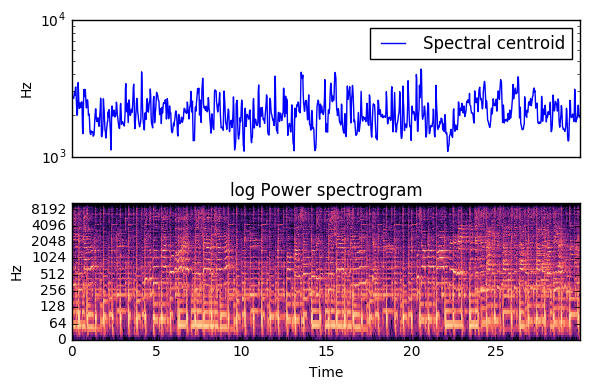

[[ 2335.10032977  2629.27085496  2734.6927377  ...,  1949.27495804
   1937.48775201  1964.36462112]]
(0, ':', 1290, ' ylen:', 660000, ' sr:', 22050)


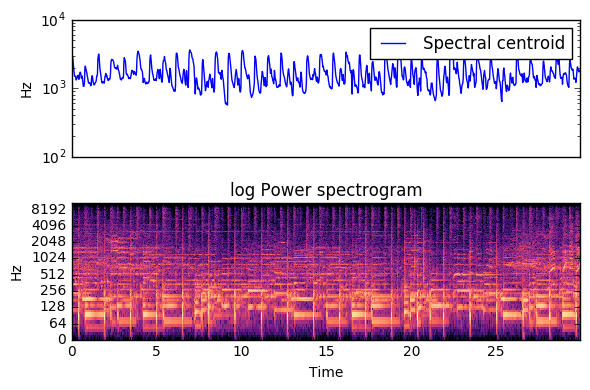

[[ 2312.82316885  2723.29467942  2834.16330255 ...,  1728.79504045
   1766.04811656  1825.29732201]]
(1, ':', 1290, ' ylen:', 660000, ' sr:', 22050)


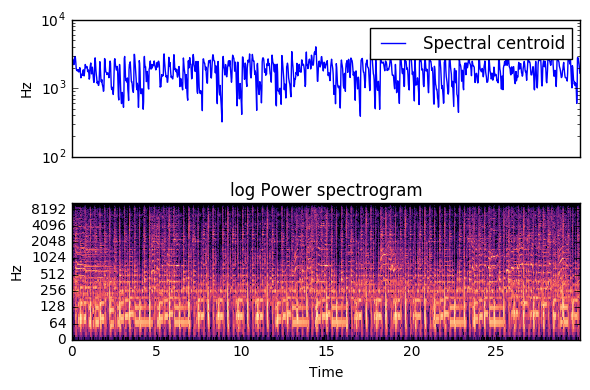

[[ 2701.72117832  2722.86982329  2648.09597231 ...,  2225.87461674
   1936.3644051   1660.01995776]]
(2, ':', 1290, ' ylen:', 660000, ' sr:', 22050)


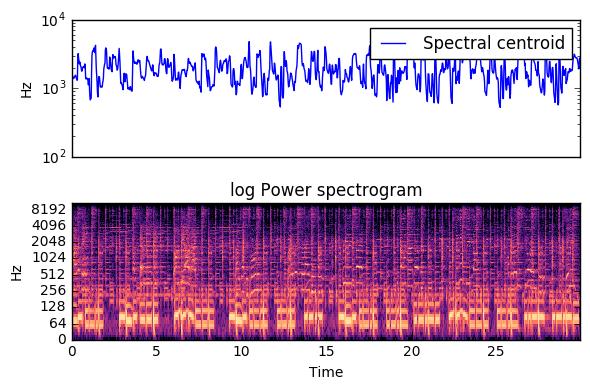

[[ 1365.04915148  1426.34357172  1480.27289264 ...,  2020.06221452
   2703.23984088  2755.63925823]]
(3, ':', 1290, ' ylen:', 660000, ' sr:', 22050)


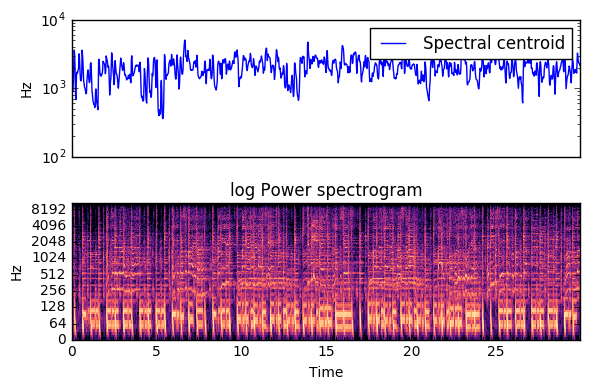

[[ 1269.19050491  1062.5556178    888.37053803 ...,  2304.98985725
   2296.31412865  2160.93124773]]
(4, ':', 1290, ' ylen:', 660000, ' sr:', 22050)


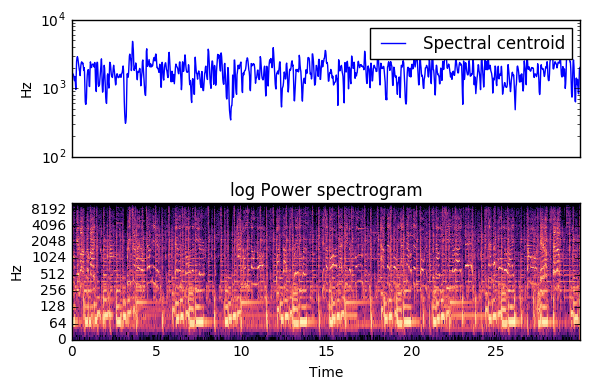

[[ 1781.2393111   1705.04639917  1626.67829708 ...,  1205.38389977
   1893.07239072  2005.94182083]]
(5, ':', 1290, ' ylen:', 660000, ' sr:', 22050)


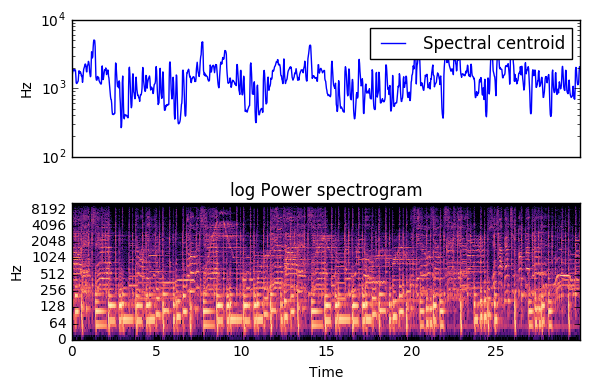

[[ 1389.47136186  1574.40305627  1730.59949907 ...,  1673.27213871
   2060.16631694  2003.17974631]]
(6, ':', 1290, ' ylen:', 660000, ' sr:', 22050)


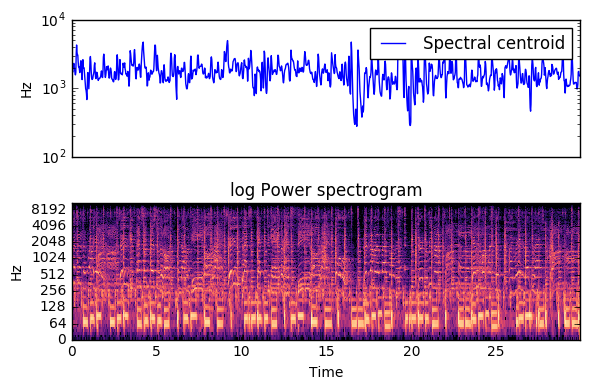

[[ 1885.05475096  1877.46009439  1713.20806299 ...,  1581.68326777
   1539.81808996  1508.0465519 ]]
(7, ':', 1290, ' ylen:', 660000, ' sr:', 22050)


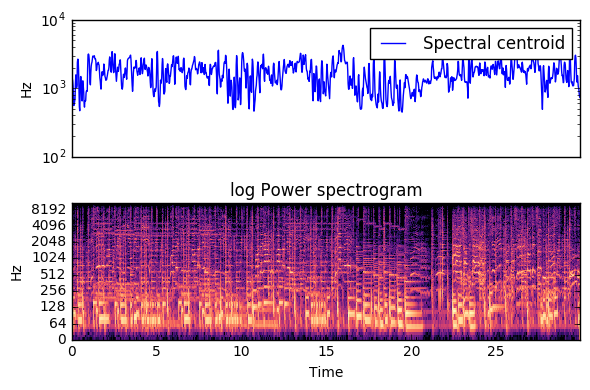

[[ 1132.10393724  1380.11751866  1286.70223232 ...,   873.116642
    770.7533269    736.74365293]]
(8, ':', 1290, ' ylen:', 660000, ' sr:', 22050)


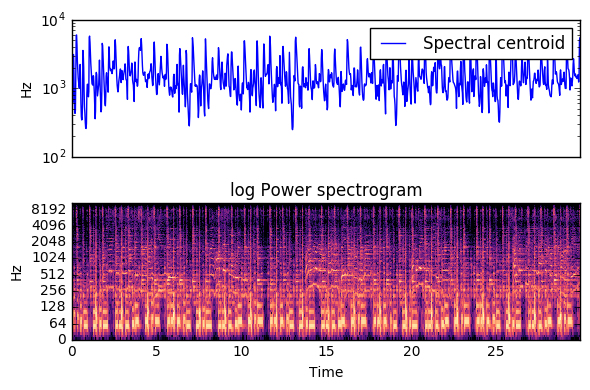

[[  950.54471546   762.25030419   617.0688468  ...,  1507.91441028
   4975.57698512  5421.90278019]]
(9, ':', 1290, ' ylen:', 660000, ' sr:', 22050)
('reggae', ' ymin:', 660000, ' max:', 660000)


../genres/blues/blues.00000.au
[ 0.00732422  0.01660156  0.00762939 ..., -0.05560303 -0.06106567
 -0.06417847]
22050
[[ 2175.02383202  2103.86995659  1955.28566719 ...,  1490.45684232
   1506.97561259  1442.64520671]]


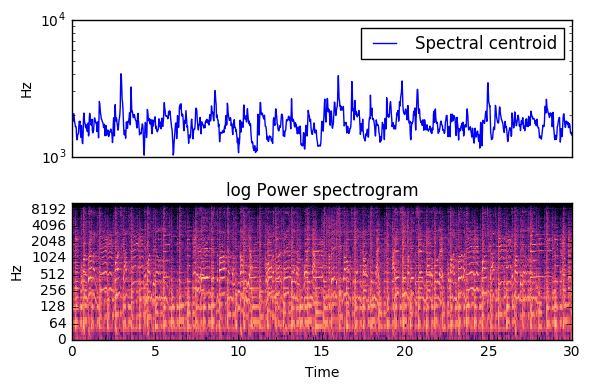

In [108]:
genre="blues";
audio_number="00000";
filename=dir+"/"+genre_dir[genre]+"/"+genre_dir[genre]+"."+audio_number+".au"; 
print(filename);
y, sr = librosa.load(filename);
stft=librosa.stft(y=y);
print(y);print(sr);
cent=librosa.feature.spectral_centroid(y=y,sr=sr);
print(cent);
S, phase = librosa.magphase(stft);
drawSpectrogramWithCentroid(cent,S);